## XModalix Port First Milestone: ImageVAE + Loader


### Outcome
- Have a image loader and image VAE
- Train this in a notebook
    - With c. elegans and MNIST images


### Checks
- Check loss curves
- Check image recons
- 


### Steps
- Prepare datasets
    - Maybe already done in 00 notebook
- Prepare config
- Write ImageDataset Class
- Write / port ImageVAE

#### IMPORTS

In [1]:
import os
from autoencodix.utils.default_config import DataConfig, DataInfo, DefaultConfig
import autoencodix as acx

notebook_dir = os.path.dirname(os.path.abspath("__file__"))
print(notebook_dir)
os.chdir(notebook_dir)
os.chdir("..")
print(os.getcwd())


/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/Users/maximilianjoas/development/autoencodix_package/notebooks
/Users/maximilianjoas/development/autoencodix_package


#### GLOBALS


In [2]:
IMGROOT = os.path.join("data/images/ALY-2_SYS721/")
IMGMAPPING = os.path.join("data/ALY-2_SYS721_mappings.txt")
NUMFILE = os.path.join("data/AM3_NO2_raw_cell.tsv")

img_config = DefaultConfig(
    data_config=DataConfig(
        epochs=50,
        data_info={
            "IMG": DataInfo(
                file_path=IMGROOT,
                data_type="IMG",
                translate_direction="to",
            ),
            "RNA": DataInfo(
                file_path=NUMFILE,
                data_type="NUMERIC",
                translate_direction="from",
            ),
            "RNA2": DataInfo(
                file_path=NUMFILE,
                data_type="NUMERIC",
                translate_direction="from",
            ),
            "ANNO": DataInfo(
                file_path=IMGMAPPING,
                data_type="ANNOTATION",
            ),
        },
    )
)

In [3]:
xmodalix = acx.XModalix(config=img_config)
ds = xmodalix.preprocess()

preprocessing
Checking data type: IMG
Found image type in config
current data info: file_path='data/images/ALY-2_SYS721/' data_type='IMG' scaling='STANDARD' filtering='VAR' sep=None extra_anno_file=None is_single_cell=False min_cells=0.05 min_genes=0.02 selected_layers=['X'] is_X=False normalize_counts=True log_transform=True k_filter=20 img_root=None img_width_resize=64 img_height_resize=64 translate_direction='to'
Checking data type: RNA
Checking data type: RNA2
Checking data type: ANNO
Given image size is possible, rescaling images to: 64x64
reading annotation file: data/ALY-2_SYS721_mappings.txt
 n_samples: {'multi_sc': {'multi_sc': 0}, 'multi_bulk': {'RNA': 260, 'RNA2': 260}, 'annotation': {'paired': 260}, 'img': {'IMG': 260}, 'from_modality': {}, 'to_modality': {}, 'paired_count': {'paired_count': 260}}
Converting 182 images to torch.float32 tensors...
Converting 52 images to torch.float32 tensors...
Converting 26 images to torch.float32 tensors...
key: train, type: <class 'dict'

/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/utils/_imgreader.py:251: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  annotation = pd.read_csv(anno_file, sep=sep)


In [15]:
trainloader = xmodalix._trainer._trainloader

In [ ]:
xmodalix.fit()
trainset = xmodalix._trainer._trainset

In [19]:
from autoencodix.modeling._varix_architecture import VarixArchitecture
from autoencodix.modeling._imagevae_architecture import ImageVAEArchitecture
# class XModaleTrainer(GeneralTrainer):

for batch in trainloader:
    dt = batch.keys()


In [ ]:
import torch
from autoencodix.base._base_dataset import DataSetTypes

def _init_modality_training(self):
    model_map = {
        DataSetTypes.NUM: VarixArchitecture,
        DataSetTypes.IMG: ImageVAEArchitecture,
    }
    modality_training_helper = {mod_name: None for mod_name in trainset.datasets.keys()}
    for mod_name, ds in trainset.datasets.items():
        model_type = model_map.get(ds.mytype)
        if model_type is None:
            raise ValueError()
        model = model_type(config=img_config, input_dim=ds.get_input_dim())
        optimizer = torch.optim.AdamW(
            params=model.parameters(),
            lr=img_config.learning_rate,
            weight_decay=img_config.weight_decay,
        )
        modality_training_helper[mod_name] = {
            "model": model,
            "optim": optimizer,
            "mp": [],
            "losses": [],
        }


In [28]:
from autoencodix.utils._losses import VarixLoss
vl = VarixLoss(config=img_config)
for k, v in batch.items():
    model = modality_training_helper[k]["model"]
    data = v["data"]
    print(data.shape)

    mp = model(data)
    losses = vl(model_output = mp, targets = data)
    break

torch.Size([42, 10])


In [31]:
type(batch)

dict

In [29]:
losses

(tensor(1.4841, grad_fn=<AddBackward0>),
 {'recon_loss': tensor(1.4592, grad_fn=<MseLossBackward0>),
  'var_loss': tensor(0.2491, grad_fn=<MulBackward0>),
  'anneal_factor': tensor(1.),
  'effective_beta_factor': tensor(0.1000)})

In [27]:
mp

ModelOutput(reconstruction=tensor([[ 3.5316e-01,  3.8315e-02,  3.9796e-01, -3.4287e-01,  6.8645e-01,
         -1.0221e-01,  3.3954e-01,  3.2503e-01, -1.8564e-01, -1.2998e-01],
        [ 4.0725e-01, -1.8167e-03,  6.4172e-01, -2.2350e-01,  6.1576e-01,
         -8.1146e-02,  3.4766e-01,  4.6479e-01, -4.2795e-02, -3.7320e-01],
        [ 4.8920e-01, -1.1728e+00, -3.4700e-01,  5.1824e-01, -7.1683e-01,
          8.7020e-01, -1.4855e-01, -6.2411e-01, -1.2013e-01,  7.0984e-01],
        [ 1.4628e+00,  1.2767e+00,  8.9870e-01, -4.1316e+00,  4.9290e+00,
          3.0400e+00,  3.0151e+00,  2.8292e+00, -1.9291e+00,  1.9676e+00],
        [ 1.0742e+00, -1.6725e+00,  3.9951e-01,  5.8651e-01, -9.2823e-01,
          1.0952e+00, -1.3803e-01, -1.3365e+00,  4.2466e-01,  3.7860e-01],
        [ 2.2930e-01,  1.9574e-01,  1.2350e-01, -1.9098e-03,  1.5330e-01,
         -1.2046e-01,  5.4052e-01,  2.5884e-01, -3.2359e-02,  2.9047e-01],
        [ 1.4516e-01, -1.7222e-01,  6.7678e-02,  4.9647e-01, -1.2683e-01,
     

In [ ]:
jkkkmodels

{'multi_bulk.RNA': VarixArchitecture(
   (_encoder): Sequential(
     (0): Linear(in_features=10, out_features=16, bias=True)
     (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): Dropout(p=0.1, inplace=False)
     (3): ReLU()
     (4): Linear(in_features=16, out_features=16, bias=True)
     (5): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (6): Dropout(p=0.1, inplace=False)
     (7): ReLU()
     (8): Linear(in_features=16, out_features=16, bias=True)
     (9): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (10): Dropout(p=0.1, inplace=False)
     (11): ReLU()
   )
   (_mu): Linear(in_features=16, out_features=16, bias=True)
   (_logvar): Linear(in_features=16, out_features=16, bias=True)
   (_decoder): Sequential(
     (0): Linear(in_features=16, out_features=16, bias=True)
     (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [ ]:
trainloader.dataset.datasets[]

In [ ]:
jds

In [17]:
batch = next(xmodalix.fit())

In [6]:
type(batch)

dict

In [7]:
print(batch.keys())
print(type(batch[list(batch.keys())[0]]))
print(batch[list(batch.keys())[0]].keys())

dict_keys(['multi_bulk.RNA', 'multi_bulk.RNA2', 'img.IMG'])
<class 'dict'>
dict_keys(['data', 'metadata', 'sample_ids', 'sampled_index', 'dtype'])


In [8]:
len(batch["multi_bulk.RNA"]["metadata"])

48

In [ ]:
len(batch["multi_bulk.RNA"]["sample_ids"])

48

In [ ]:
import pandas as pd
import numpy as np

nacount = 0
for i, md in enumerate(batch["multi_bulk.RNA"]["metadata"]):
    if md is None:
        print("none for")
        print(batch["multi_bulk.RNA"]["sample_ids"][i])


In [11]:
md = batch["multi_bulk.RNA"]["metadata"]
md

,img_paths,extra_class_labels,early
T_44,ALY-2_SYS721_t44.tif,44,'0'
T_22,ALY-2_SYS721_t22.tif,22,'1'
T_205,ALY-2_SYS721_t205.tif,205,'0'
T_259,ALY-2_SYS721_t259.tif,259,'0'
T_158,ALY-2_SYS721_t158.tif,158,'0'
T_5,ALY-2_SYS721_t5.tif,5,'1'
T_25,ALY-2_SYS721_t25.tif,25,'1'
T_141,ALY-2_SYS721_t141.tif,141,'0'
T_255,ALY-2_SYS721_t255.tif,255,'0'
T_86,ALY-2_SYS721_t86.tif,86,'0'


In [ ]:
import numpy as np

np.stack(md)

array(['img_paths', 'extra_class_labels', 'early'], dtype='<U18')

In [13]:
batch["img.IMG"]["dtype"]

[]

## Training Xmodal artefact

In [14]:
fo

NameError: name 'fo' is not defined

## Imagix
If we want to use a standard image vae, we can use the Imagix pipeline. Note that only one image dataset is allowed here
**NOTE**:
set the datacase in config to DataCase.IMG_TO_IMG

In [ ]:
import autoencodix as acx
from autoencodix.utils.default_config import (
    DefaultConfig,
    DataConfig,
    DataCase,
    DataInfo,
)
import os

IMGROOT = os.path.join("data/images/ALY-2_SYS721/")
IMGMAPPING = os.path.join("data/ALY-2_SYS721_mappings.txt")
NUMFILE = os.path.join("data/AM3_NO2_raw_cell.tsv")

img_config2 = DefaultConfig(
    data_case=DataCase.IMG_TO_IMG,
    data_config=DataConfig(
        data_info={
            "IMG": DataInfo(
                file_path=IMGROOT,
                data_type="IMG",
            ),
            "ANNO": DataInfo(
                file_path=IMGMAPPING,
                data_type="ANNOTATION",
            ),
        },
    ),
)

imagix = acx.Imagix(config=img_config2)
imagix.preprocess()
imagix.fit()

preprocessing
Checking data type: IMG
Found image type in config
current data info: file_path='data/images/ALY-2_SYS721/' data_type='IMG' scaling='STANDARD' filtering='VAR' sep=None extra_anno_file=None is_single_cell=False min_cells=0.05 min_genes=0.02 selected_layers=['X'] is_X=False normalize_counts=True log_transform=True k_filter=20 img_root=None img_width_resize=64 img_height_resize=64 translate_direction=None
Checking data type: ANNO
Given image size is possible, rescaling images to: 64x64
reading annotation file: data/ALY-2_SYS721_mappings.txt
 n_samples: {'multi_sc': {'multi_sc': 0}, 'multi_bulk': {'multi_bulk': 0}, 'annotation': {'annotation': 0}, 'img': {'IMG': 260}, 'from_modality': {}, 'to_modality': {}, 'paired_count': {'paired_count': 260}}
Converting 182 images to torch.float32 tensors...
Converting 52 images to torch.float32 tensors...
Converting 26 images to torch.float32 tensors...


/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/utils/default_config.py:426: UserWarning: Could not determine data_case: No numeric datasets found in data_info
  warnings.warn(f"Could not determine data_case: {str(e)}")
/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/utils/_imgreader.py:251: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  annotation = pd.read_csv(anno_file, sep=sep)


Epoch 1/3 - Train Loss: 2183.8016
Sub-losses: recon_loss: 2183.8014, var_loss: 25.3807, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 1/3 - Valid Loss: 243.6502
Sub-losses: recon_loss: 243.6502, var_loss: 0.8540, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 2/3 - Train Loss: 2166.0510
Sub-losses: recon_loss: 2165.9005, var_loss: 43.6877, anneal_factor: 0.0344, effective_beta_factor: 0.0034
Epoch 2/3 - Valid Loss: 242.6190
Sub-losses: recon_loss: 242.6075, var_loss: 3.3543, anneal_factor: 0.0344, effective_beta_factor: 0.0034
split: train
self._reconstruction_buffer shape: torch.Size([182, 1, 64, 64])
indices_np shape: (32,)
split: train
self._reconstruction_buffer shape: torch.Size([182, 1, 64, 64])
indices_np shape: (32,)
split: train
self._reconstruction_buffer shape: torch.Size([182, 1, 64, 64])
indices_np shape: (32,)
split: train
self._reconstruction_buffer shape: torch.Size([182, 1, 64, 64])
indices_np shape: (32,)
split: train
self._reconstruction_buff

In [ ]:
imagix.predict()

self.n_test: 52
setting n_features in init_buffers: torch.Size([1, 64, 64])
split: test
self._reconstruction_buffer shape: torch.Size([52, 1, 64, 64])
indices_np shape: (32,)
split: test
self._reconstruction_buffer shape: torch.Size([52, 1, 64, 64])
indices_np shape: (20,)


Result Object Public Attributes:
------------------------------
latentspaces: TrainingDynamics object
sample_ids: TrainingDynamics object
reconstructions: TrainingDynamics object
mus: TrainingDynamics object
sigmas: TrainingDynamics object
losses: TrainingDynamics object
sub_losses: LossRegistry(_losses={'recon_loss': TrainingDynamics(), 'var_loss': TrainingDynamics(), 'anneal_factor': TrainingDynamics(), 'effective_beta_factor': TrainingDynamics()})
preprocessed_data: Tensor of shape (0,)
model: ImageVAEArchitecture
model_checkpoints: TrainingDynamics object
datasets: DatasetContainer(train=<autoencodix.data._image_dataset.ImageDataset object at 0x322989a80>, valid=<autoencodix.data._image_dataset.ImageDataset object at 0x322989900>, test=<autoencodix.data._image_dataset.ImageDataset object at 0x322989c90>)
new_datasets: DatasetContainer(train=None, valid=None, test=None)
adata_latent: AnnData object with n_obs × n_vars = 52 × 16
    uns: 'var_names'
final_reconstruction: <autoencodix

In [ ]:
r = imagix.result
r.final_reconstruction
sample_img = r.final_reconstruction.data[0, :, :, :]
sample_img = sample_img.squeeze()

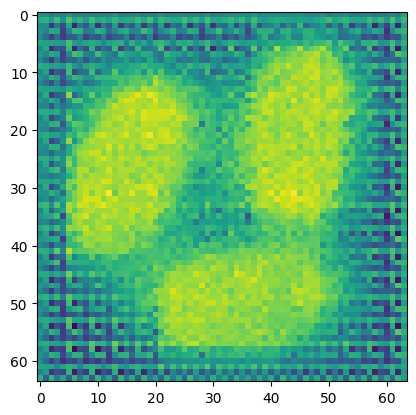

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(sample_img.numpy())

### Old, maybe reuse code for getting stats, but seemd to work

In [ ]:
# Simple statistics tracking - just build the dict in your training loop

# Initialize stats dict once before training
stats = {}
for modality in trainset.datasets.keys():
    stats[modality] = {}
    for sample_id in trainset.datasets[modality].sample_ids:
        stats[modality][sample_id] = 0
print(stats)
# Training loop
epochs = 100

# Add this to your training loop
for epoch in range(100):  # Just test first 5 epochs
    batch_count = 0
    for batch_idx, batch in enumerate(dataloader):
        batch_count += 1

    print(f"Epoch {epoch}: {batch_count} batches processed")

    # Also check sampler length
    print(f"Sampler length: {len(sampler)}")
    print(f"Dataset length: {len(trainset)}")
    print(f"Paired samples: {len(trainset.paired_sample_ids)}")
    print(f"Unpaired samples: {len(trainset.unpaired_sample_ids)}")
    # # Reset stats for new epoch
    # for modality in stats:
    #     for sample_id in stats[modality]:
    #         stats[modality][sample_id] = 0

    for batch_idx, batch in enumerate(dataloader):
        # Update stats with current batch
        for modality, data in batch.items():
            if "sample_ids" in data:
                for sample_id in data["sample_ids"]:
                    if sample_id in stats[modality]:
                        stats[modality][sample_id] += 1

        # Your training code here
        # for modality, data in batch.items():
        #     if data["data"] is not None:
        #         outputs = models[modality](data["data"])

    # Print simple summary at end of epoch
    print("\nSampling Stats:")
    for modality in stats:
        counts = list(stats[modality].values())
        seen = sum(1 for c in counts if c > 0)
        total = len(counts)
        avg = sum(counts) / len(counts) if counts else 0
        print(f"  {modality}: {seen}/{total} samples seen, avg: {avg:.2f}")

    # Optional: Print unseen samples
    print("\nUnseen samples:")
    for modality in stats:
        unseen = [sid for sid, count in stats[modality].items() if count == 0]
        if unseen:
            print(
                f"  {modality}: {len(unseen)} unseen - {unseen[:5]}{'...' if len(unseen) > 5 else ''}"
            )

# Access raw stats anytime:
# stats = {
#     "img.IMG": {"T_98": 3, "T_138": 2, "T_183": 1, ...},
#     "multi_bulk.RNA": {"T_98": 4, "T_138": 3, "T_173": 2, ...},
#     ...
# }

NameError: name 'trainset' is not defined